# V - 1D computations

The two following links might help you during the computation of 1D flames :<br>
https://cantera.org/documentation/docs-2.4/sphinx/html/cython/onedim.html <br>
https://cantera.org/science/flames.html
<br>
The first one is about the function that can be used for computing a one dimensional flame and the second one explains the equations that are computed.<br>
The main difference between Cantera and a solver like AVBP is that equations are already one dimensional in Cantera.

## 1. ADIABATIC FLAME - A freely-propagating, premixed flat flame 

<p class="bg-primary" style="padding:1em"> This script will show you the creation of a premixed flame. First the initial solution is created and then, the calculation is performed before plotting the interesting results. </p> 

In [1]:
import cantera as ct
import numpy as np
from matplotlib.pylab import *

### 1.1 Initial solution

#### Import solution

In [2]:
gas = ct.Solution('gri30.cti')                  # Import gas phases with mixture transport model

#### Set the parameters

In [3]:
# General
p = 1e5                                         # pressure
tin = 600.0                                     # unburned gas temperature
phi = 0.8                                       # equivalence ratio

fuel = {'CH4': 1}                               # Methane composition
oxidizer = {'O2': 1, 'N2': 3.76}                # Oxygen composition

#### Set gas state to that of the unburned gas

In [4]:
gas.TP = tin, p
gas.set_equivalence_ratio(phi, fuel, oxidizer)

#### Create the flame and set inlet conditions

In [5]:
f = ct.FreeFlame(gas, width=0.02)   # Create the free laminar premixed flame specifying the width of the grid
f.inlet.X = gas.X                   # Inlet condition on mass fraction
f.inlet.T = gas.T                   # Inlet condition on temperature

### 1.2 Program starts here

<p class="bg-primary" style="padding:1em"> The idea here is to solve four flames to make the calculation converge. The first flame will be solved without equation energy whereas the others will continue the computation by enabling the calculation using the equation energy and by adding more point to the flame front. </p> 

#### First flame

In [6]:
f.energy_enabled = False                       # No energy for starters

tol_ss = [1.0e-5, 1.0e-9]  # tolerance [rtol atol] for steady-state problem
tol_ts = [1.0e-5, 1.0e-9]  # tolerance [rtol atol] for time stepping

f.flame.set_steady_tolerances(default=tol_ss)
f.flame.set_transient_tolerances(default=tol_ts)

# Set calculation parameters
f.set_max_jac_age(50, 50)                           # Maximum number of times the Jacobian will be used before it 
                                                    # must be re-evaluated
f.set_time_step(1.0e-5, [2, 5, 10, 20, 80])         # Set time steps (in seconds) whenever Newton convergence fails 
f.set_refine_criteria(ratio=10.0, slope=1, curve=1) # Refinement criteria

# Calculation
loglevel = 1                                        # amount of diagnostic output (0 to 5)
refine_grid = 'disabled'                            # 'refine' or 'remesh' to enable refinement
                                                    # 'disabled' to disable

f.solve(loglevel, refine_grid)                                      # solve the flame on the grid
f.save('4-Output/ch4_adiabatic.xml', 'no energy','solution with no energy')  # save solution


..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 2 timesteps       1.5e-05      1.624
Attempt Newton solution of steady-state problem...    failure. 
Take 5 timesteps     7.594e-05      1.356
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0002162      1.814
Attempt Newton solution of steady-state problem...    failure. 
Take 20 timesteps       0.01184     -1.328
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).

..............................................................................
grid refinement disabled.
Solution saved to file 4-Output/ch4_adiabatic.xml as solution no energy.


#### Second flame

In [7]:
%%capture
f.energy_enabled = True                                 # Energy equation enabled
refine_grid = 'refine'                                 # Calculation and save of the results

f.set_refine_criteria(ratio=5.0, slope=0.5, curve=0.5)  # Refinement criteria when energy equation is enabled

f.solve(loglevel, refine_grid)
f.save('4-Output/ch4_adiabatic.xml', 'energy', 'solution with the energy equation enabled')

In [8]:
print('mixture-averaged flamespeed = {0:7f} m/s'.format(f.u[0]))  # m/s

mixture-averaged flamespeed = 1.138558 m/s


#### Third flame and so on ...

In [9]:
%%capture
f.set_refine_criteria(ratio=2.0, slope=0.05, curve=0.05) # Refinement criteria should be changed ...

f.solve(loglevel, refine_grid)                           
f.save('4-Output/ch4_adiabatic.xml', 'energy continuation','solution with the energy equation enabled continuation')

In [10]:
points = f.flame.n_points
print('mixture-averaged flamespeed continuation = {0:7f} m/s'.format(f.u[0]))  # m/s
print('mixture-averaged final T = {0:7f} K'.format(f.T[points - 1]))  # K

mixture-averaged flamespeed continuation = 1.070030 m/s
mixture-averaged final T = 2201.068248 K


#### Fourth flame and so on ...

In [11]:
%%capture

f.transport_model = 'Multi'      # Switch transport model

f.solve(loglevel, refine_grid)

f.save('4-Output/ch4_adiabatic.xml', 'energy_multi',
       'solution with the multicomponent transport and energy equation enabled')

In [12]:
points = f.flame.n_points
print('multicomponent flamespeed = {0:7f} m/s'.format(f.u[0]))  # m/s
print('multicomponent final T = {0:7f} K'.format(f.T[points - 1]))  # K

multicomponent flamespeed = 1.081526 m/s
multicomponent final T = 2201.849447 K


You may notice that there are small differences on the flamespeed and on the final temperature between the two transport models, as it was predictable.

### 1.3 Manipulate the results

#### Save your results

In [13]:
f.write_csv('4-Output/ch4_adiabatic.csv', quiet=False)  # Write the velocity, temperature, density, and mole fractions 
                                               # to a CSV file

Solution saved to '4-Output/ch4_adiabatic.csv'.


#### Plot your results (temperature, density, velocity, ...)

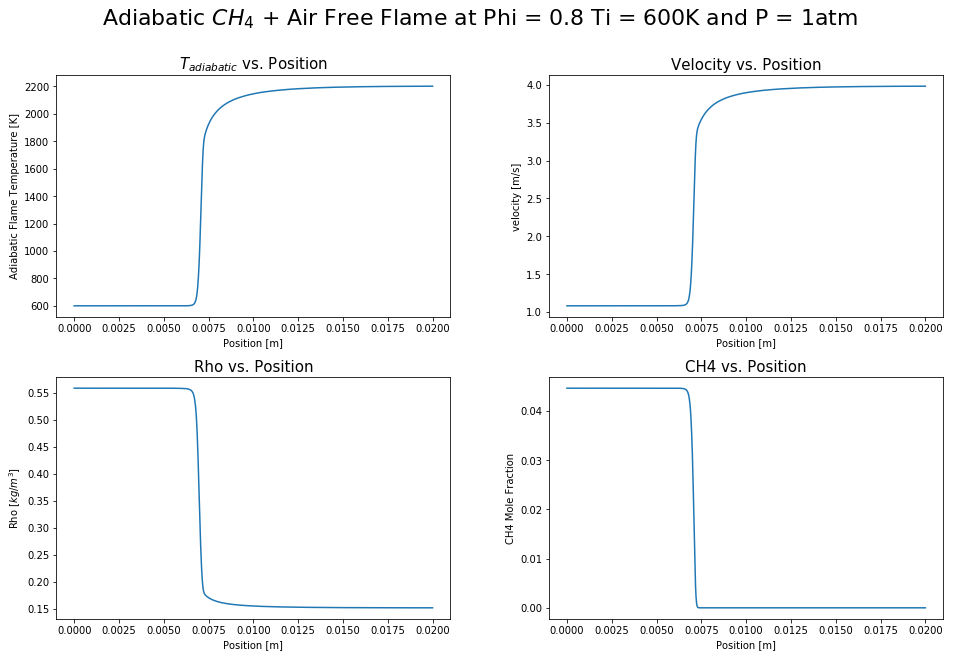

In [14]:
rcParams['figure.figsize'] = (14, 10)

# Get the different arrays
z = f.flame.grid
T = f.T
u = f.u
ifuel = gas.species_index('CH4')

fig=figure(1)

# create first subplot - adiabatic flame temperature
a=fig.add_subplot(221)
a.plot(z,T)
title(r'$T_{adiabatic}$ vs. Position', fontsize=15)
xlabel(r'Position [m]')
ylabel("Adiabatic Flame Temperature [K]")
a.xaxis.set_major_locator(MaxNLocator(10)) # this controls the number of tick marks on the axis

# create second subplot - velocity
b=fig.add_subplot(222)
b.plot(z,u)
title(r'Velocity vs. Position', fontsize=15)
xlabel(r'Position [m]')
ylabel("velocity [m/s]")
b.xaxis.set_major_locator(MaxNLocator(10)) 

# create third subplot - rho
c=fig.add_subplot(223)
p = zeros(f.flame.n_points,'d')
for n in range(f.flame.n_points):
    f.set_gas_state(n)
    p[n]= gas.density_mass
c.plot(z,p)
title(r'Rho vs. Position', fontsize=15)
xlabel(r'Position [m]')
ylabel("Rho [$kg/m^3$]")
c.xaxis.set_major_locator(MaxNLocator(10)) 


# create fourth subplot - specie CH4
d=fig.add_subplot(224)
ch4 = zeros(f.flame.n_points,'d')
for n in range(f.flame.n_points):
    f.set_gas_state(n)
    ch4[n]= gas.Y[ifuel]
d.plot(z,ch4)
title(r'CH4 vs. Position', fontsize=15)
xlabel(r'Position [m]')
ylabel("CH4 Mole Fraction")
d.xaxis.set_major_locator(MaxNLocator(10))

# Set title
fig.text(0.5,0.95,r'Adiabatic $CH_{4}$ + Air Free Flame at Phi = 0.8 Ti = 600K and P = 1atm',fontsize=22,horizontalalignment='center')

subplots_adjust(left=0.08, right=0.96, wspace=0.25, hspace=0.25)

<div class="alert alert-danger "><b> The plots here describe the flame front. The evolution of the variables and the different values seem coherent with the simulation.  </b></div>

## 2. A burner-stabilized rich premixed methane-oxygen flame at low pressure

<p class="bg-primary" style="padding:1em"> This script will show you the creation of a burner. This is basically the same thing as a premixed flame, except that the flame is stabilized on a burner and not freely proapagating. </p> 

![title](Images/burnervsfree.pdf)
From R.J. Kee, M.E. Coltrin and P. Glarborg *Chemically Reacting Flow*

### 2.1 Initial solution

<div class="alert alert-danger "><b> Try to set a solution from :<br>
- the gri30 mechanism (CH4/air flame) <br>
- with a pressure of 1 bar, a temperature of 373 K, an equivalence ratio of 1.3
<b></div>

In [15]:
# Import gas phases with mixture transport model
gas = ct.Solution('gri30.cti')

# Parameter values :
# General
p = 1e5  # pressure
tin = 373  # unburned gas temperature
phi = 1.3

fuel = 'CH4: 1'
oxidizer = 'O2:1.0, N2:3.76'

# Set gas state to that of the unburned gas
gas.TP = tin, p
gas.set_equivalence_ratio(phi, fuel, oxidizer)

<div class="alert alert-danger "><b> Try to construct a BurnerFlame of width 2 cm and implement the limit conditions (f.burner instead of f.inlet for this case).
<b></div>

In [16]:
f = ct.BurnerFlame(gas, width=0.2)

f.burner.T =  gas.T
f.burner.X =  gas.X              # Conditions

mdot = 0.04
f.burner.mdot = mdot

Here, the strategy is, as above, a four step calculation. For the purpose of this training, we have commented lines so that the result is only done in one calculation.<br>
As you might notice, the calculation works and it converges, but it takes more time than doing it by running four calculations.<br>
Therefore, the choice is entirely yours and dependent on the fuel you are using (heptane will take more time to converge than methane for instance).<br><br>
It is possible that your flame does not converge in some simulations (sometimes, the Newton solver used to compute the flame is crashing if the chemistry is too sharp - meaning that the chemical timesteps are very small - or for other reasons). You have several parameters that you can play on to make it work :
- increase or decrease the tolerances for steady-state and time stepping (whether absolute or relative).
- increase your ratio in the refine criteria.
- take a slower time step with more steps.<br>

NB : If you do not want the solver to plot the lines of computing, just uncomment the **%%capture** command.<br>
NB2 : Note that two functions might be useful for your future developments :
- if you want to **save** a solution in a xml file, you can use the <code>save()</code> function on the freeflame object.
- if you want to **restore** a solution from a xml file, you can use the <code>restore()</code> function. This is very useful if you want to analyse old results or if you want a flame to converge without starting from a linear initialization.

NB3 : To specify the grid refinement criteria, it is possible to set the function <code>set_refine_criteria</code> with correct values. This enables to have more control on the way the solver refine the curve. The different fields definitions are :<br>
- **ratio** : additional points will be added if the ratio of the spacing on either side of a grid point exceeds
this value
- **slope** : maximum difference in value between two adjacent points, scaled by the maximum difference in the profile (0.0 < slope < 1.0). Adds points in regions of high slope.
- **curve** : maximum difference in slope between two adjacent intervals, scaled by the maximum difference in the profile (0.0 < curve < 1.0). Adds points in regions of high curvature.
- **prune** : if the slope or curve criteria are satisfied to the level of prune, the grid point is assumed not to be needed and is removed. Set prune significantly smaller than slope and curve. Set to zero to disable pruning the grid.<br>
For a first computation, it is best to put the ratio value to a sufficiently high value; and to let the
'slope' and 'curve' values to 1. Use 'prune' if you see that Cantera tries to refine your grid too much,
and that the number of points starts to exceed a reasonable value (approximately 200 points is enough).

In [17]:
#%%capture
#################
#f.energy_enabled = False

tol_ss = [1.0e-5, 1.0e-9]  # [rtol atol] for steady-state
tol_ts = [1.0e-5, 1.0e-4]  # [rtol atol] for time stepping

f.flame.set_steady_tolerances(default=tol_ss)
f.flame.set_transient_tolerances(default=tol_ts)

f.set_refine_criteria(ratio=10.0, slope=1, curve=1)

f.set_max_jac_age(50, 50)

f.set_time_step(1.0e-5, [1, 2, 5, 10, 20])

loglevel = 1  # amount of diagnostic output (0 to 5)

#refine_grid = 'refine'  # True to enable refinement, False to

#f.solve(loglevel, refine_grid)

#f.save('4-Output/ch4_burner_flame.xml', 'no_energy',
#       'solution with the energy equation disabled')

#################
f.energy_enabled = True

f.set_refine_criteria(ratio=3.0, slope=0.1, curve=0.2)

#f.solve(loglevel, refine_grid='refine')

#f.save('4-Output/ch4_burner_flame.xml', 'energy',
#       'solution with the energy equation enabled')

#################
f.transport_model = 'Multi'

#f.solve(loglevel, refine_grid='refine')

#f.save('4-Output/ch4_burner_flame.xml', 'energy_multi',
#       'solution with the energy equation enabled and multicomponent transport')

#################
f.soret_enabled = True

f.solve(loglevel, refine_grid='refine')

f.save('4-Output/ch4_burner_flame.xml', 'energy_soret',
       'solution with the energy equation enabled and multicomponent transport')



..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 1 timesteps       1.5e-05      5.342
Attempt Newton solution of steady-state problem...    failure. 
Take 2 timesteps     3.375e-05      4.579
Attempt Newton solution of steady-state problem...    failure. 
Take 5 timesteps     0.0002563      3.704
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001539      5.737
Attempt Newton solution of steady-state problem...    failure. 
Take 20 timesteps      0.004213      4.328
Attempt Newton solution of steady-state problem...    failure. 
Take 20 timesteps          0.82      2.376
Attempt Newton solution of steady-state problem...    success.

Problem solved on [7] point grid(s).

..............................................................................
##############################################################################
Refining grid in flam

<div class="alert alert-danger "><b> Here the plot is for the temperature. Try to change it to plot the laminar flame speed.
<b></div>

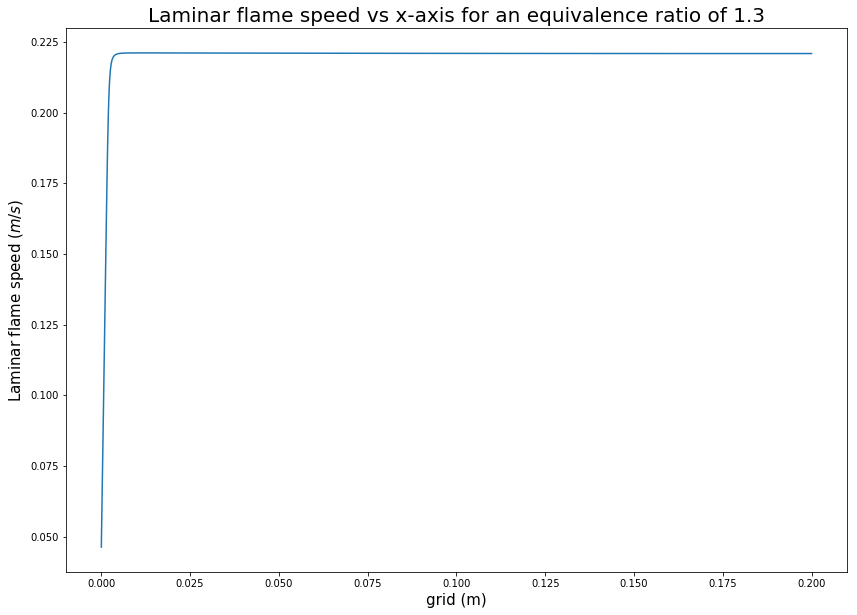

Solution saved to '4-Output/ch4_burner_flame.csv'.


In [18]:
import matplotlib.pyplot as plt
plt.plot(f.grid, f.u)
plt.xlabel('grid (m)',fontsize=15)
plt.ylabel('Laminar flame speed ($m/s$)',fontsize=15)
plt.title('Laminar flame speed vs x-axis for an equivalence ratio of 1.3', fontsize=20)
plt.show()

f.write_csv('4-Output/ch4_burner_flame.csv', quiet=False)

NB : This type of flame is not used in practice as most of the combustion chambers are based on the study of premixed flames configurations.. Nevertheless, it can be useful for some special configurations that you may want to study.<br>
Next, we will see the **counter-flow diffusion flame** as this is an important configuration to study when studying a combustion chamber. However, if you need to look for other types, some more are available (see above).

## 3. An opposed-flow ethane/air diffusion flame

A counter-flow diffusion flame is basically a flame where the oxidizer and the fuel meet to burn (they are not mixed before burning, contrary to the two others types that we have seen before).

![title](Images/CDF.png)
From Pfitzner, Michael & Müller, Hagen & Ferraro, Federica. (2013). Implementation of a Steady Laminar Flamelet Model for nonpremixed combustion in LES and RANS simulations. 

First of all, the solution object is instanciated as usual. The mass flow rate of the oxidizer and the fuel have been fitted so that the flame is in stoichiometric conditions. In addition to the composition, the temperature and the pressure, the density and the mass flow rate are given. By dividing the second by the first, the velocity of each gases is given which leads to the calculation of the strain rate, an important parameter to counter-flow diffusion flame.

In [21]:
gas = ct.Solution('gri30.xml', 'gri30_mix')

p = 1e5  # pressure

comp_f = 'C2H6:1'                       # fuel composition
tin_f = 300.0                           # fuel inlet temperature

rho_f = p / (8.314 / 0.030 * tin_f)     # fuel inlet density
mdot_f = 0.24                           # fuel inlet mass flow rate (kg/m^2/s)
vel_f = mdot_f / rho_f                  # fuel inlet velocity
print('Velocity of the fuel : ' + str(vel_f))

comp_o = 'O2:0.21, N2:0.78, AR:0.01'    # oxidizer composition
tin_o = 300.0                           # oxidizer inlet temperature

rho_o = p / (8.314 / 0.029 * tin_o)     # oxidizer inlet density
mdot_o = 0.72                           # oxidizer inlet mass flow rate (kg/m^2/s)
vel_o = mdot_o / rho_o                  # oxidizer inlet velocity
print('Velocity of the oxidizer : ' + str(vel_o))

gas.TP = tin_o, p

width = 0.02
a = (vel_o + vel_f) / width              # calculation of the strain rate (s^-1)
print('Strain rate of the diffusion flame : ' + str(a))

Velocity of the fuel : 0.19953599999999996
Velocity of the oxidizer : 0.6192496551724137
Strain rate of the diffusion flame : 40.93928275862068


This will instanciate the counterflow diffusion flame. As you might notice, and this is valid for all the other cases, you can instanciate the initial grid yourself. This allows you to refine the grid when you want. This can be a good trick when your simulation is crashing and you want to compute it again.<br><br>
As far as the inlets are concerned, the composition, temperature and mass flow rate needs to be specified.

In [22]:
initial_grid = np.linspace(0, width, 6)
f = ct.CounterflowDiffusionFlame(gas, initial_grid)

# Set the state of the two inlets
f.fuel_inlet.mdot = mdot_f
f.fuel_inlet.X = comp_f
f.fuel_inlet.T = tin_f

f.oxidizer_inlet.mdot = mdot_o
f.oxidizer_inlet.X = comp_o
f.oxidizer_inlet.T = tin_o

This starts the calculation of the counterflow diffusion flame. By experience, you will see that, out of this wonderful tutorial case, diffusion flames are hard to converge. You can either play with the size of the domain and every parameter said all along the tutorial (indeed, sometimes it converges better if the domain is smaller), or you can try a method that is developed here in CERFACS that resolves **the diffusion flame in the z-space**.<br>
If you want some more information about that, come and ask the chemistry team of cerfacs.

In [23]:
#%%capture
# First flame:
# disable the energy equation
f.energy_enabled = False

# Set error tolerances
tol_ss = [1.0e-5, 1.0e-11]  # [rtol, atol] for steady-state problem
tol_ts = [1.0e-5, 1.0e-11]  # [rtol, atol] for time stepping
f.flame.set_steady_tolerances(default=tol_ss)
f.flame.set_transient_tolerances(default=tol_ts)

# and solve the problem without refining the grid
f.solve(loglevel=1, refine_grid='disabled')

#################
# Second flame:
# specify grid refinement criteria, turn on the energy equation,
f.energy_enabled = True

f.set_refine_criteria(ratio=3, slope=0.8, curve=0.8)

# and solve the problem again
f.solve(loglevel=1, refine_grid='refine')

# save your results
f.save('4-Output/c2h6_diffusion.xml', 'energy')

#################
# Third flame:
# specify grid refinement criteria, turn on the energy equation,
f.energy_enabled = True

f.set_refine_criteria(ratio=2, slope=0.2, curve=0.2, prune=0.04)

# and solve the problem again
f.solve(loglevel=1, refine_grid='refine')

# save your results
f.save('4-Output/c2h6_diffusion.xml', 'energy continuation')

#################################################################
# Save your results if needed
#################################################################
# write the velocity, temperature, and mole fractions to a CSV file
f.write_csv('4-Output/c2h6_diffusion.csv', quiet=False)


..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.848e-05      4.327
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0007298      3.785
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.01247        1.5
Attempt Newton solution of steady-state problem...    success.

Problem solved on [6] point grid(s).

..............................................................................
grid refinement disabled.

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0002563      5.361
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.001297      4.781
Attempt Newton solution of steady-state problem...    success.

Problem solved on [6] point grid(s

These are interesting quantities to plot, such as the different mass fractions and the temperature of the flame. This is all done in the following graph (with the values being adimensionalised).

In [24]:
# Get interesting values
z = f.flame.grid
T = f.T
u = f.u

# Get interesting indices for computation of species
fuel_species = 'C2H6'
ifuel = gas.species_index(fuel_species)
io2 = gas.species_index('O2')
in2 = gas.species_index('N2')

# Initiate interesting vectors
c2h6 = np.zeros(f.flame.n_points,'d')
o2 = np.zeros(f.flame.n_points,'d')
hr = np.zeros(f.flame.n_points,'d')

# Computes interesting quantities for analyzing a counter-flow flame
for n in range(f.flame.n_points):
    f.set_gas_state(n)
    c2h6[n]= gas.Y[ifuel]
    o2[n]= gas.Y[io2]
    hr[n] = - np.dot(gas.net_production_rates, gas.partial_molar_enthalpies)

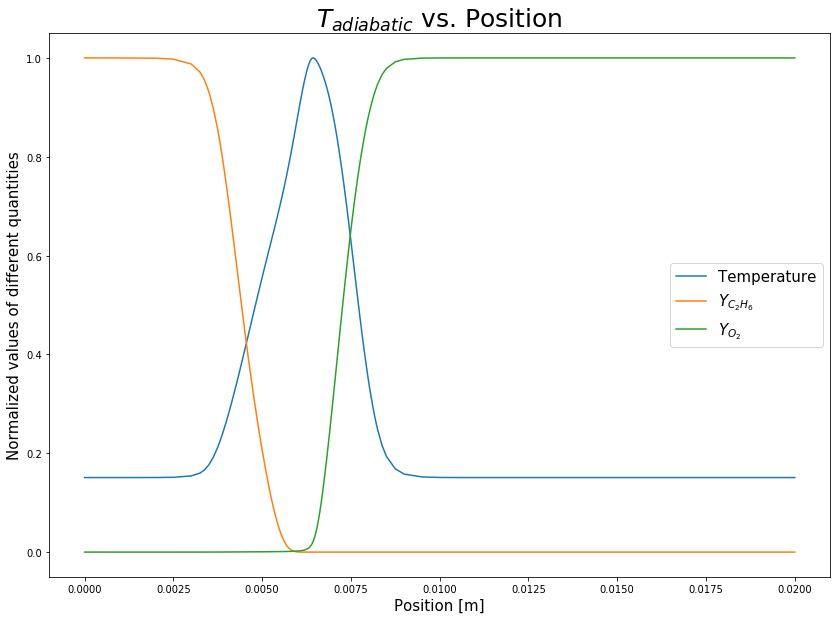

In [25]:
fig=figure(1)

a=fig.add_subplot(111)
a.plot(z,T/np.max(T),z,c2h6/np.max(c2h6),z,o2/np.max(o2))
plt.title(r'$T_{adiabatic}$ vs. Position',fontsize=25)
plt.xlabel(r'Position [m]', fontsize=15)
plt.ylabel('Normalized values of different quantities',fontsize=15)
plt.legend(['Temperature','$Y_{C_2H_6}$', '$Y_{O_2}$'],fontsize=15)
show()

## 4. Compute your own premixed flame

Please go on the website :<br>
https://chemistry.cerfacs.fr/fr/

You will find the reference website of cerfacs as far as chemistry is concerned. If you go to **Chemical Database** and **Data table**, you will notice that several mechanisms can be used for your computation.

<div class="alert alert-danger "><b> The task now will be to :<br>
- compute two premixed flames : one including the gri30 and the other the Lu.cti (under methane/skeletal on the website).<br>
- the flames will be fuel/air at an equivalence ratio of 1.1, a cold gases temperature of 400K and a pressure of 2 bars.<br>
- Try to post-process your data by plotting the flame speed of both flames.<br>
The solution you are supposed to get is shown below.<br>
NB : the transport used should be a mix one.<b></div>

![title](Images/Comparison.png)

### Here is where you should code your premixed flame


..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 2 timesteps       1.5e-05      1.861
Attempt Newton solution of steady-state problem...    failure. 
Take 5 timesteps     7.594e-05      1.662
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.001946     0.8802
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).

..............................................................................
grid refinement disabled.

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 2 timesteps      2.25e-05      5.733
Attempt Newton solution of steady-state problem...    failure. 
Take 5 timesteps     1.424e-05      6.463
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.027e-05      6

/Users/wirtz/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


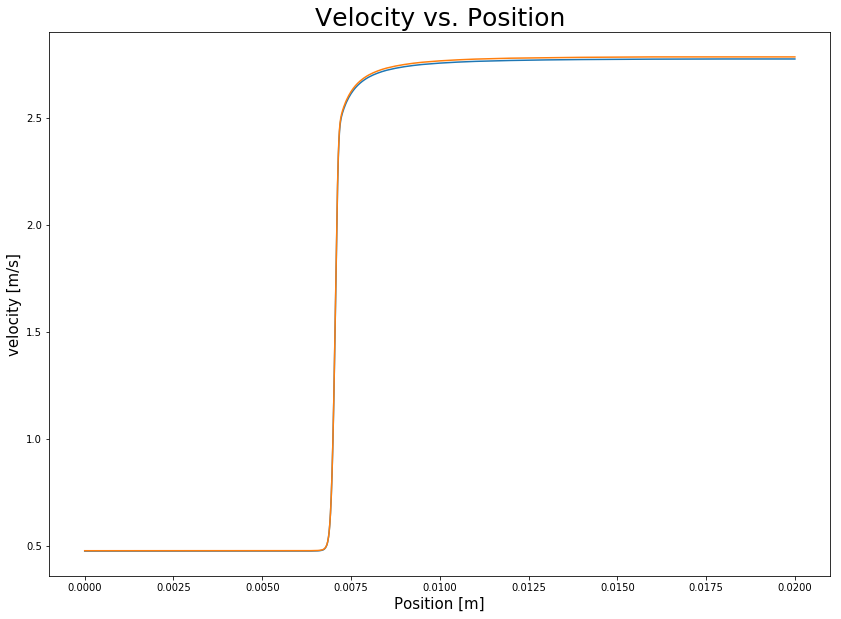

In [27]:
import cantera as ct
import numpy as np
from matplotlib.pylab import *

names = ['gri30.cti', 'Mechanisms/Lu.cti']
fuels = ['CH4','CH4']
fig=figure(1)
for i,n in enumerate(names):
    gas = ct.Solution(n)                            # Import gas phases with mixture transport model

    p = 2e5                                         # pressure
    tin = 400.0                                     # unburned gas temperature
    phi = 1.1                                       # equivalence ratio

    fuel = {fuels[i]: 1}                            # Fuel composition
    oxidizer = {'O2': 1, 'N2': 3.76}                # Oxygen composition
    
    gas.TP = tin, p
    gas.set_equivalence_ratio(phi, fuel, oxidizer)
    
    f = ct.FreeFlame(gas, width=0.02)   # Create the free laminar premixed flame specifying the width of the grid
    f.inlet.X = gas.X                   # Inlet condition on mass fraction
    f.inlet.T = gas.T                   # Inlet condition on temperature
    
    f.energy_enabled = False                       # No energy for starters

    tol_ss = [1.0e-5, 1.0e-9]  # tolerance [rtol atol] for steady-state problem
    tol_ts = [1.0e-5, 1.0e-9]  # tolerance [rtol atol] for time stepping

    f.flame.set_steady_tolerances(default=tol_ss)
    f.flame.set_transient_tolerances(default=tol_ts)

    # Set calculation parameters
    f.set_max_jac_age(50, 50)                           # Maximum number of times the Jacobian will be used before it 
                                                        # must be re-evaluated
    f.set_time_step(1.0e-5, [2, 5, 10, 20, 80])         # Set time steps (in seconds) whenever Newton convergence fails 
    f.set_refine_criteria(ratio=10.0, slope=1, curve=1) # Refinement criteria

    # Calculation
    loglevel = 1                                        # amount of diagnostic output (0 to 5)
    refine_grid = 'disabled'                            # 'refine' or 'remesh' to enable refinement
                                                    # 'disabled' to disable

    f.solve(loglevel, refine_grid)                                      # solve the flame on the grid

    f.energy_enabled = True                                 # Energy equation enabled
    refine_grid = 'refine'                                 # Calculation and save of the results

    f.set_refine_criteria(ratio=5.0, slope=0.5, curve=0.5)  # Refinement criteria when energy equation is enabled

    f.solve(loglevel, refine_grid)

    f.set_refine_criteria(ratio=2.0, slope=0.05, curve=0.05) # Refinement criteria should be changed ...
    f.solve(loglevel, refine_grid)                           


    rcParams['figure.figsize'] = (14, 10)

    # Get the different arrays
    z = f.flame.grid
    u = f.u
    ifuel = gas.species_index(fuels[i])

    # create second subplot - velocity
    b=fig.add_subplot(111)
    b.plot(z,u)
    title(r'Velocity vs. Position', fontsize=25)
    xlabel(r'Position [m]', fontsize=15)
    ylabel("velocity [m/s]", fontsize=15)
    b.xaxis.set_major_locator(MaxNLocator(10)) 
plt.show()
fig.savefig('4-Output/Comparison.png')

This introduces the notion of types of mechanisms. To represent your chemistry, you will have :
- **detailed mechanisms** such as the gri30 which are very complete but also containing a lot of species (so hard to integrate into solvers such as AVBP).
- **global mechanisms** that are very simple (usually 6 species and 2 equations) but that may be inaccurate.
- **ARC mechanisms** that are an inbetween solution (among others) and that is chosen to be used at CERFACS. The Lu mechanism used here is an intermediate step to access to an ARC mechanism and thus shows some differences with the detailed, as you might see on the graph.<br>

Nevertheless, be always careful when you use this or this detailed mechanism as a reference for your computations. Indeed, it might be accurate with a certain error bar or developed for special conditions that are not yours.